In [1]:
from src.metrics.utils import early_stopping, early_stopping_loss, get_mean_window
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

def load_json_metrics(file_path):
    with open(file_path, 'r') as fp:
        metrics = json.load(fp)
    return metrics

In [2]:
latex = True
#plotting and colour set ups
if latex:
#     mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
#         'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [3]:
d = {
    'no_snow_test': {'unet': {'0':[], '33': [], '66': [], '100':[]}, 
                     'small': {'0':[], '33': [], '66': [], '100':[]}, 
                     'mobile': {'0':[], '33': [], '66': [], '100':[]}}, 
    'half_snow_test': {'unet': {'0':[], '33': [], '66': [], '100':[]}, 
                       'small': {'0':[], '33': [], '66': [], '100':[]}, 
                       'mobile': {'0':[], '33': [], '66': [], '100':[]}},
    'all_snow_test': {'unet': {'0':[], '33': [], '66': [], '100':[]}, 
                      'small': {'0':[], '33': [], '66': [], '100':[]}, 
                      'mobile': {'0':[], '33': [], '66': [], '100':[]}}
    }

In [4]:
results_dir = '/home/dsola/repos/PGA-Net/results/'
stopping_epochs = 30
avg_half_window = 5

for snow_dir in ['snow_amount', 'snow_amount_2', 'snow_amount_3']:
#     fig, axs = plt.subplots(1,3, figsize=(15,3))
    no_snow_list = [x for x in os.listdir(os.path.join(results_dir, snow_dir)) if 'iou' in x and 'eval_imgs-' in x]
    half_snow_list = [x for x in os.listdir(os.path.join(results_dir, snow_dir)) if 'iou' in x and 'half_snow' in x]
    snow_list = [x for x in os.listdir(os.path.join(results_dir, snow_dir)) if 'iou' in x and 'eval_imgs_snow' in x]
    batch_list = [no_snow_list, half_snow_list, snow_list]
    title_list = ['no_snow_test', 'half_snow_test', 'all_snow_test']
    i = 0
    for title, test_set_batch in zip(title_list, batch_list):
        unet = [x for x in test_set_batch if 'unet' in x and 'small' not in x]
        small = [x for x in test_set_batch if 'small' in x]
        mobile = [x for x in test_set_batch if 'mobile' in x]
        models = [unet, small, mobile]
        model_names = ['unet', 'small', 'mobile']
        for model_name, model_list in zip(model_names, models):
            snow_0 = [x for x in model_list if 'imgs_dir' in x][0]
            snow_33 = [x for x in model_list if 'imgs_one' in x][0]
            snow_66 = [x for x in model_list if 'imgs_two' in x][0]
            snow_100 = [x for x in model_list if 'imgs_snow' in x][0]

            final_metric_list = []
            train_snow_props = ['0', '33', '66', '100']
            for train_snow_prop, json_path in zip(train_snow_props, [snow_0, snow_33, snow_66, snow_100]):
                metric_dict = load_json_metrics(os.path.join(results_dir, snow_dir, json_path))
                metric_list = list(metric_dict.values())
                argmx = np.argmax(metric_list)
                mean_score = np.mean(metric_list[max(0, argmx-avg_half_window):min(argmx+avg_half_window, len(metric_list))])
                d[title][model_name][train_snow_prop].append(mean_score)
                final_metric_list.append(mean_score)

#             axs[i].plot([0, 33.3, 66.6, 100], final_metric_list, label=model_name)
#         axs[i].legend()
#         axs[i].set_ylabel('mIoU')
#         axs[i].set_title(title)
#         axs[i].set_xlabel('Percent Snow Amount in Training Set');
#         i += 1

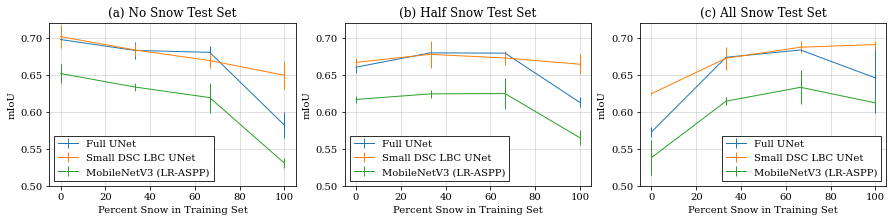

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
i = 0
for title, test_set in zip(['(a) No Snow Test Set', '(b) Half Snow Test Set', '(c) All Snow Test Set'], d.keys()):
    for model, model_name in zip(d[test_set].keys(), ['Full UNet', 'Small DSC LBC UNet', 'MobileNetV3 (LR-ASPP)']):
        means, stds = [], []
        for prop in ['0', '33', '66', '100']:
            if test_set=='no_snow_test' and model=='unet' and prop=='0':
                means.append(0.6973179479440054)
            elif test_set=='no_snow_test' and model=='small' and prop=='0':
                means.append(0.7012618907860347)
            elif test_set=='no_snow_test' and model=='mobile' and prop=='0':
                means.append(0.6514462039584205)
            else:
                means.append(np.mean(d[test_set][model][prop]))
            stds.append(np.std(d[test_set][model][prop]))
        axs[i].errorbar([0, 33.3, 66.6, 100], means, stds, label=model_name, linewidth=1.0)
    axs[i].legend()
    axs[i].set_ylabel('mIoU')
    axs[i].set_title(title)
    axs[i].grid(alpha=0.5)
    axs[i].set_ylim(0.5, 0.72)
    leg4 = axs[i].legend(framealpha=1.0, fancybox=False)
    leg4.get_frame().set_edgecolor('k')
    leg4.get_frame().set_linewidth(0.8)
    leg4.get_frame().set_facecolor('w')
    axs[i].set_xlabel('Percent Snow in Training Set');
    i += 1

In [11]:
# fig.savefig("../images/snow_testing.svg", format='svg', dpi=1200)

In [25]:
d['no_snow_test']

{'unet': {'0': [0.7018028914928436, 0.6797948002815246, 0.6917099893093109],
  '33': [0.674252200126648, 0.6744429409503937, 0.6991718292236329],
  '66': [0.6716374099254608, 0.6905978143215179, 0.6779643952846527],
  '100': [0.5921328796280755, 0.5956542313098907, 0.5575250834226608]},
 'small': {'0': [0.6945145395067003, 0.6773704716137477, 0.7140692949295044],
  '33': [0.6729619264602661, 0.6825769543647766, 0.6941778481006622],
  '66': [0.6681297183036804, 0.6824905157089234, 0.6563197195529937],
  '100': [0.6741121768951416, 0.6293355107307435, 0.6438280284404755]},
 'mobile': {'0': [0.6221194522721427, 0.6519527912139893, 0.6423547029495239],
  '33': [0.6311928749084472, 0.6283518016338349, 0.6400395452976226],
  '66': [0.6437546491622925, 0.6192050099372863, 0.5940344989299774],
  '100': [0.5359183967113494, 0.5206687718629837, 0.5348331034183502]}}

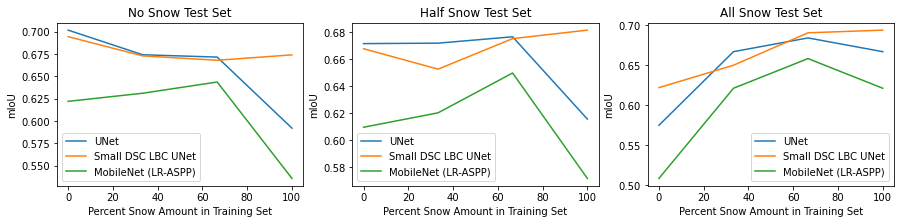

In [2]:
results_dir = '/home/dsola/repos/PGA-Net/results/snow_amount'
stopping_epochs = 30
avg_half_window = 5

fig, axs = plt.subplots(1,3, figsize=(15,3))
no_snow_list = [x for x in os.listdir(results_dir) if 'iou' in x and 'eval_imgs-' in x]
half_snow_list = [x for x in os.listdir(results_dir) if 'iou' in x and 'half_snow' in x]
snow_list = [x for x in os.listdir(results_dir) if 'iou' in x and 'eval_imgs_snow' in x]
batch_list = [no_snow_list, half_snow_list, snow_list]
title_list = ['No Snow Test Set', 'Half Snow Test Set', 'All Snow Test Set']
i = 0
for title, test_set_batch in zip(title_list, batch_list):
    unet = [x for x in test_set_batch if 'unet' in x and 'small' not in x]
    small = [x for x in test_set_batch if 'small' in x]
    mobile = [x for x in test_set_batch if 'mobile' in x]
    models = [unet, small, mobile]
    model_names = ['UNet', 'Small DSC LBC UNet', 'MobileNet (LR-ASPP)']
    for model_name, model_list in zip(model_names, models):
        snow_0 = [x for x in model_list if 'imgs_dir' in x][0]
        snow_33 = [x for x in model_list if 'imgs_one' in x][0]
        snow_66 = [x for x in model_list if 'imgs_two' in x][0]
        snow_100 = [x for x in model_list if 'imgs_snow' in x][0]

        final_metric_list = []
        for json_path in [snow_0, snow_33, snow_66, snow_100]:
            metric_dict = load_json_metrics(os.path.join(results_dir, json_path))
            metric_list = list(metric_dict.values())
            argmx = np.argmax(metric_list)
            mean_score = np.mean(metric_list[max(0, argmx-avg_half_window):min(argmx+avg_half_window, len(metric_list))])
            final_metric_list.append(mean_score)

        axs[i].plot([0, 33.3, 66.6, 100], final_metric_list, label=model_name)
    axs[i].legend()
    axs[i].set_ylabel('mIoU')
    axs[i].set_title(title)
    axs[i].set_xlabel('Percent Snow Amount in Training Set');
    i += 1
    

In [76]:
final_metric_list

[nan, 0.6313042442003886, 0.6479276021321615, 0.5387543340524038]

In [54]:
metric_list[53:59]

[0.6817381978034973,
 0.7458329200744629,
 0.714961051940918,
 0.7227091789245605,
 0.6918222308158875,
 0.7452384829521179]

In [55]:
stop

56

In [56]:
metric_list[56]

0.7227091789245605

In [20]:
1//2

0